# Looking at averages with the data

In [49]:
import pandas as pd
df = pd.read_csv('games1.csv')

#  Win rate calculations
win_rate_white = len(df[df['result'] == '1-0']) / len(df) * 100
win_rate_black = len(df[df['result'] == '0-1']) / len(df) * 100
draw_rate = len(df[df['result'] == '1/2-1/2']) / len(df) * 100

print(f"White Win Rate: {win_rate_white:.2f}%")
print(f"Black Win Rate: {win_rate_black:.2f}%")
print(f"Draw Rate: {draw_rate:.2f}%")


White Win Rate: 49.92%
Black Win Rate: 46.48%
Draw Rate: 3.59%


In [50]:
# Grouping ELO by ranges
df['white_elo'] = pd.to_numeric(df['white_elo'], errors='coerce')
df['black_elo'] = pd.to_numeric(df['black_elo'], errors='coerce')
df['elo_range'] = pd.cut(df[['white_elo', 'black_elo']].mean(axis=1), bins=[0, 1200, 1400, 1600, 1800, 2000, 2200, 2400], labels=['<1200', '1200-1400', '1400-1600', '1600-1800', '1800-2000', '2000-2200', '>2200'])

# Find average inaccuracies by ELO range
mistakes_by_elo = df.groupby('elo_range')[['white_inaccuracies', 'black_inaccuracies']].mean()
print(mistakes_by_elo)

           white_inaccuracies  black_inaccuracies
elo_range                                        
<1200                2.470008            2.508682
1200-1400            2.615385            2.600190
1400-1600            2.616856            2.629109
1600-1800            2.838897            2.904499
1800-2000            2.906936            2.929936
2000-2200            2.785079            2.844368
>2200                2.921911            2.874126


In [51]:
df['white_elo'] = pd.to_numeric(df['white_elo'], errors='coerce')
df['black_elo'] = pd.to_numeric(df['black_elo'], errors='coerce')
df['elo_range'] = pd.cut(df[['white_elo', 'black_elo']].mean(axis=1), bins=[0, 1200, 1400, 1600, 1800, 2000, 2200, 2400], labels=['<1200', '1200-1400', '1400-1600', '1600-1800', '1800-2000', '2000-2200', '>2200'])

# Mistakes instead
mistakes_by_elo = df.groupby('elo_range')[['white_mistakes', 'black_mistakes']].mean()
print(mistakes_by_elo)


           white_mistakes  black_mistakes
elo_range                                
<1200            1.168508        1.174033
1200-1400        1.123457        1.157645
1400-1600        1.122236        1.130006
1600-1800        1.187228        1.190131
1800-2000        1.197098        1.212668
2000-2200        1.138834        1.131423
>2200            1.155012        1.149184


In [52]:
df['white_elo'] = pd.to_numeric(df['white_elo'], errors='coerce')
df['black_elo'] = pd.to_numeric(df['black_elo'], errors='coerce')
df['elo_range'] = pd.cut(df[['white_elo', 'black_elo']].mean(axis=1), bins=[0, 1200, 1400, 1600, 1800, 2000, 2200, 2400], labels=['<1200', '1200-1400', '1400-1600', '1600-1800', '1800-2000', '2000-2200', '>2200'])

# Blunders
mistakes_by_elo = df.groupby('elo_range')[['white_blunders', 'black_blunders']].mean()
print(mistakes_by_elo)


           white_blunders  black_blunders
elo_range                                
<1200            2.313733        2.329124
1200-1400        2.121083        2.119658
1400-1600        2.065152        2.055589
1600-1800        1.926560        1.882729
1800-2000        1.843241        1.824133
2000-2200        1.658103        1.675395
>2200            1.741259        1.688811


In [53]:
import scipy.stats as stats

total_games = len(df)
white_wins = len(df[df['result'] == '1-0'])
black_wins = len(df[df['result'] == '0-1'])
white_proportion = white_wins / total_games
black_proportion = black_wins / total_games

# Find pooled proportion
pooled_proportion = (white_wins + black_wins) / total_games

# Get sample sizes
n_white = total_games
n_black = total_games

# Calculate z-score
z_stat = (white_proportion - black_proportion) / (
    (pooled_proportion * (1 - pooled_proportion) * (1 / n_white + 1 / n_black)) ** 0.5
)


p_value = 1 - stats.norm.cdf(z_stat)

print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("Reject the null hypothesis: White wins significantly more than Black.")
else:
    print("Fail to reject the null hypothesis: No significant difference in win rates.")


Z-statistic: 17.2564
P-value: 0.0000
Reject the null hypothesis: White wins significantly more than Black.


In [60]:
import numpy as np
import scipy.stats as stats

# Divide by average ELO
df['avg_elo'] = (df['white_elo'] + df['black_elo']) / 2
lower_elo = df[df['avg_elo'] < 2000]
higher_elo = df[df['avg_elo'] >= 2000]

# NOTE: This is 2 tailed
def z_test(group1, group2, column1, column2):
    n1, n2 = len(group1), len(group2)
    mean1, mean2 = (group1[column1] + group1[column2]).mean(), (group2[column1] + group2[column2]).mean()
    var1 = ((group1[column1] + group1[column2]).var(ddof=1))
    var2 = ((group2[column1] + group2[column2]).var(ddof=1))
    
    z_stat = (mean1 - mean2) / np.sqrt(var1 / n1 + var2 / n2)
    p_value = 2 * (1 - stats.norm.cdf(abs(z_stat)))

    return z_stat, p_value

tests = [('white_inaccuracies', 'black_inaccuracies'), 
         ('white_mistakes', 'black_mistakes'), 
         ('white_blunders', 'black_blunders')]

for test in tests:
    z, p = z_test(lower_elo, higher_elo, test[0], test[1])
    print(f"Z-test for combined {test[0].replace('white_', '')}:")
    print(f"  Z-statistic: {z:.4f}, P-value: {p:.4f}")
    if p < 0.05:
        print("  Significant difference between lower and higher Elo groups.")
    else:
        print("  No significant difference.")


Z-test for combined inaccuracies:
  Z-statistic: -3.1726, P-value: 0.0015
  Significant difference between lower and higher Elo groups.
Z-test for combined mistakes:
  Z-statistic: 1.9793, P-value: 0.0478
  Significant difference between lower and higher Elo groups.
Z-test for combined blunders:
  Z-statistic: 11.3134, P-value: 0.0000
  Significant difference between lower and higher Elo groups.


### Lower has more than Upper

In [61]:
import numpy as np
import scipy.stats as stats

# THIS is 1 tailed (lower favored)
def one_tailed_z_test(group1, group2, column1, column2):
    n1, n2 = len(group1), len(group2)
    mean1, mean2 = (group1[column1] + group1[column2]).mean(), (group2[column1] + group2[column2]).mean()
    var1 = ((group1[column1] + group1[column2]).var(ddof=1))
    var2 = ((group2[column1] + group2[column2]).var(ddof=1))
    
    z_stat = (mean1 - mean2) / np.sqrt(var1 / n1 + var2 / n2)
    p_value = 1 - stats.norm.cdf(z_stat)

    return z_stat, p_value

for test in tests:
    z, p = one_tailed_z_test(lower_elo, higher_elo, test[0], test[1])
    print(f"One-Tailed Z-test for combined {test[0].replace('white_', '')}:")
    print(f"  Z-statistic: {z:.4f}, P-value: {p:.4f}")
    if p < 0.05:
        print("  Significant evidence that lower Elo games have more of this.")
    else:
        print("  No significant evidence of a difference.")


One-Tailed Z-test for combined inaccuracies:
  Z-statistic: -3.1726, P-value: 0.9992
  No significant evidence of a difference.
One-Tailed Z-test for combined mistakes:
  Z-statistic: 1.9793, P-value: 0.0239
  Significant evidence that lower Elo games have more of this.
One-Tailed Z-test for combined blunders:
  Z-statistic: 11.3134, P-value: 0.0000
  Significant evidence that lower Elo games have more of this.


### Upper has higher than lower

In [62]:
# Opposite
def one_tailed_z_test_flipped(group1, group2, column1, column2):
    n1, n2 = len(group1), len(group2)
    mean1, mean2 = (group1[column1] + group1[column2]).mean(), (group2[column1] + group2[column2]).mean()
    var1 = ((group1[column1] + group1[column2]).var(ddof=1))
    var2 = ((group2[column1] + group2[column2]).var(ddof=1))
    
    z_stat = (mean1 - mean2) / np.sqrt(var1 / n1 + var2 / n2)
    p_value = stats.norm.cdf(z_stat)

    return z_stat, p_value

for test in tests:
    z, p = one_tailed_z_test_flipped(lower_elo, higher_elo, test[0], test[1])
    print(f"One-Tailed Z-test for combined {test[0].replace('white_', '')} (higher > lower):")
    print(f"  Z-statistic: {z:.4f}, P-value: {p:.4f}")
    if p < 0.05:
        print("  Significant evidence that higher Elo games have more of this.")
    else:
        print("  No significant evidence of a difference.")


One-Tailed Z-test for combined inaccuracies (higher > lower):
  Z-statistic: -3.1726, P-value: 0.0008
  Significant evidence that higher Elo games have more of this.
One-Tailed Z-test for combined mistakes (higher > lower):
  Z-statistic: 1.9793, P-value: 0.9761
  No significant evidence of a difference.
One-Tailed Z-test for combined blunders (higher > lower):
  Z-statistic: 11.3134, P-value: 1.0000
  No significant evidence of a difference.


#### Possibly due to endgame battles etc...

# Regression

In [63]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('games1.csv') 

# Make sure ELO is numeric
df['white_elo'] = pd.to_numeric(df['white_elo'], errors='coerce') 
df['black_elo'] = pd.to_numeric(df['black_elo'], errors='coerce')

# Average ELO calcs & define the target
df['avg_elo'] = (df['white_elo'] + df['black_elo']) / 2  
df['white_win'] = (df['result'] == '1-0').astype(int)     

# Drop NaNs
df.dropna(subset=['avg_elo', 'white_mistakes', 'black_mistakes', 'white_win'], inplace=True)


# Standardizing the average ELO
scaler = StandardScaler()
df['avg_elo_std'] = scaler.fit_transform(df[['avg_elo']])

X = df[['avg_elo_std', 'white_mistakes', 'black_mistakes', 'white_inaccuracies', 'black_inaccuracies', 'white_blunders', 'black_blunders']]

y = df['white_win']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

log_reg = LogisticRegression(max_iter=1000)  # Ensure convergence for large datasets
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)
print(classification_report(y_test, y_pred))

coef_df = pd.DataFrame({'Predictor': ['Intercept'] + X.columns.tolist(), 
                        'Coefficient': [log_reg.intercept_[0]] + list(log_reg.coef_[0])})
print(coef_df)


              precision    recall  f1-score   support

           0       0.80      0.78      0.79      1749
           1       0.77      0.79      0.78      1674

    accuracy                           0.79      3423
   macro avg       0.79      0.79      0.79      3423
weighted avg       0.79      0.79      0.79      3423

            Predictor  Coefficient
0           Intercept     0.042640
1         avg_elo_std    -0.010313
2      white_mistakes    -0.516763
3      black_mistakes     0.497439
4  white_inaccuracies    -0.309743
5  black_inaccuracies     0.300359
6      white_blunders    -1.021781
7      black_blunders     1.016079


Funny thing is that it saw the avg_elo as a positive toward white as it went higher (though it is negligible so whatever)

### Visualization

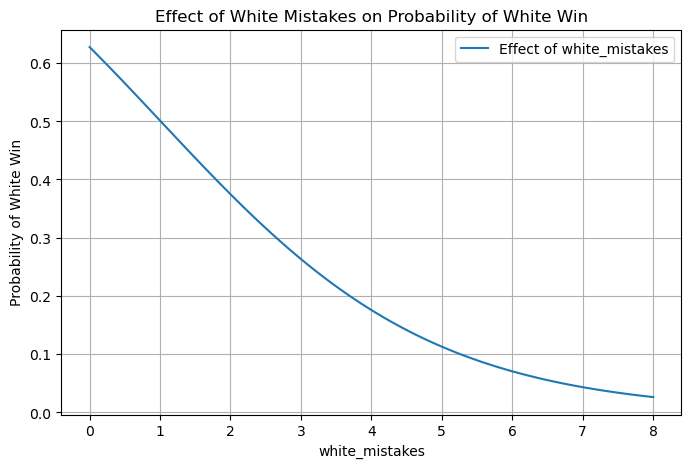

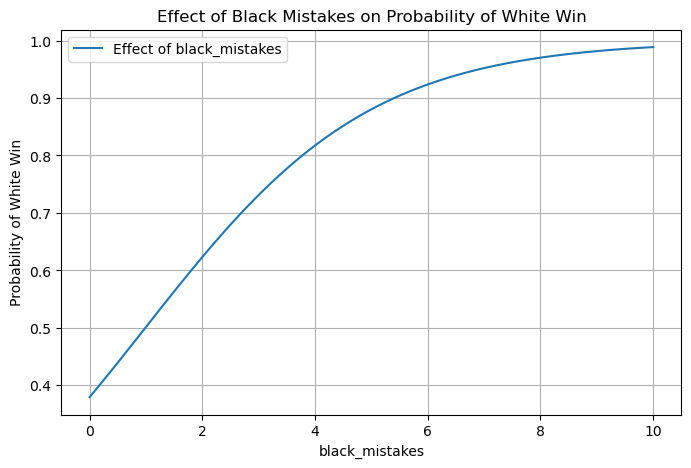

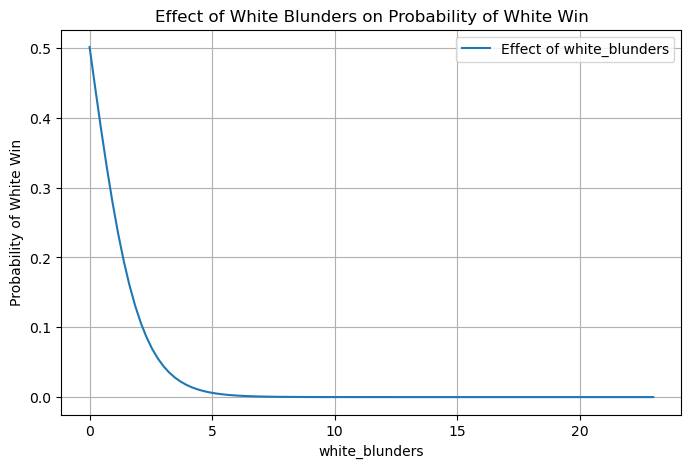

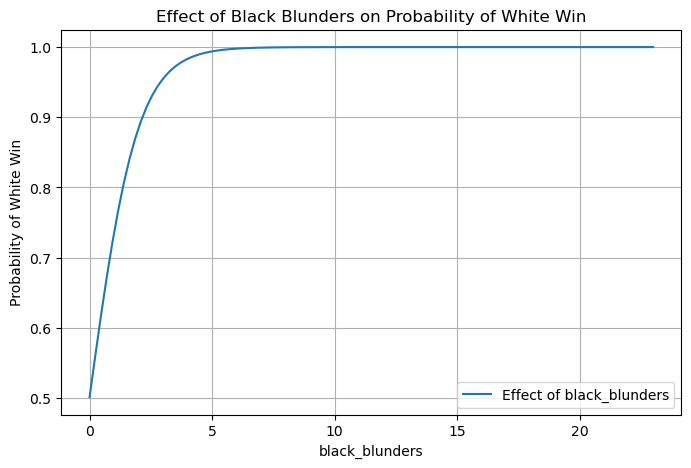

In [41]:
# Try plotting the effect of the predictors
def plot_predictor_effect(predictor, X, log_reg, fixed_values, title):
    x_values = np.linspace(X[predictor].min(), X[predictor].max(), 100)  
    X_plot = pd.DataFrame({predictor: x_values})  
    
    # Fix the values for the other predictors
    for col, value in fixed_values.items():
        if col != predictor:  
            X_plot[col] = value
    
    X_plot = X_plot[X.columns]
    
    # Predict probability of white win
    probabilities = log_reg.predict_proba(X_plot)[:, 1]  
    
    # Plot stuff
    plt.figure(figsize=(8, 5))
    plt.plot(x_values, probabilities, label=f"Effect of {predictor}")
    plt.title(title)
    plt.xlabel(predictor)
    plt.ylabel("Probability of White Win")
    plt.legend()
    plt.grid()
    plt.show()

# Assigning the fixed values for other predictors
fixed_values = {
    "avg_elo": df['avg_elo'].mean(),
    "white_mistakes": 1,
    "black_mistakes": 1,
    "white_inaccuracies": 1,
    "black_inaccuracies": 1,
    "white_blunders": 0,
    "black_blunders": 0
}

# Plot for key predictors
# The mistakes and inaccuracies one look about the same
plot_predictor_effect("white_mistakes", X, log_reg, fixed_values, "Effect of White Mistakes on Probability of White Win")
plot_predictor_effect("black_mistakes", X, log_reg, fixed_values, "Effect of Black Mistakes on Probability of White Win")
plot_predictor_effect("white_blunders", X, log_reg, fixed_values, "Effect of White Blunders on Probability of White Win")
plot_predictor_effect("black_blunders", X, log_reg, fixed_values, "Effect of Black Blunders on Probability of White Win")


In [64]:
import statsmodels.api as sm
from scipy.stats import chi2

# Intercept-only model (can be just a constant)
X_null = sm.add_constant(X[['avg_elo_std']])  
null_model = sm.Logit(y, X_null).fit()

# Full model (with all predictors)
X_full = sm.add_constant(X)  
full_model = sm.Logit(y, X_full).fit()

# Likelihood ratio test
lr_stat = 2 * (full_model.llf - null_model.llf) 
df_diff = X_full.shape[1] - X_null.shape[1]    
p_value = chi2.sf(lr_stat, df_diff)           

print(f"Likelihood Ratio Test Statistic: {lr_stat}")
print(f"Degrees of Freedom: {df_diff}")
print(f"P-Value: {p_value}")

if p_value < 0.05:
    print("The model is statistically significant.")
else:
    print("The model is not statistically significant.")


Optimization terminated successfully.
         Current function value: 0.693113
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.508201
         Iterations 6
Likelihood Ratio Test Statistic: 6329.555460686144
Degrees of Freedom: 6
P-Value: 0.0
The model is statistically significant.


In [65]:
import statsmodels.api as sm
from scipy.stats import chi2

X_full = sm.add_constant(X)  
logit_model = sm.Logit(y, X_full).fit()

print(logit_model.summary())


Optimization terminated successfully.
         Current function value: 0.508201
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              white_win   No. Observations:                17115
Model:                          Logit   Df Residuals:                    17107
Method:                           MLE   Df Model:                            7
Date:                Wed, 04 Dec 2024   Pseudo R-squ.:                  0.2668
Time:                        18:36:42   Log-Likelihood:                -8697.9
converged:                       True   LL-Null:                       -11863.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0538      0.036      1.491      0.136      -0.017       0.125
avg_e

LLR p-value is from a chi squared test on the log liklihood ratio statistic

# Deep Learning

In [43]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn import metrics
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('games1.csv')  

# handle bad values
df['white_elo'] = pd.to_numeric(df['white_elo'], errors='coerce')
df['black_elo'] = pd.to_numeric(df['black_elo'], errors='coerce')
df.dropna(subset=['white_elo', 'black_elo'], inplace=True) 

X = df[['white_elo', 'black_elo', 'white_mistakes', 'black_mistakes', 'white_inaccuracies', 'black_inaccuracies', 'white_blunders', 'black_blunders']].values
y = (df['result'] == '1-0').astype(int).values 

# Normalizing
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# same stuff like from class
def create_model():
    model = Sequential()
    model.add(Dense(128, input_dim=X.shape[1], activation='relu')) 
    model.add(Dropout(0.3))  
    model.add(Dense(64, activation='relu')) 
    model.add(BatchNormalization()) 
    model.add(Dropout(0.2))  
    model.add(Dense(32, activation='relu')) 
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))  
    model.add(Dense(1, activation='sigmoid'))  
    
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model


In [44]:
model = create_model()
# early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(
    X_train, y_train, validation_data=(X_test, y_test),
    epochs=20, batch_size=32, verbose=2
)

scores = model.evaluate(X_test, y_test, verbose=0)
print(f"Accuracy: {scores[1] * 100:.2f}%")

model.summary()


Epoch 1/20


C:\Users\ripst\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


428/428 - 2s - 4ms/step - accuracy: 0.6833 - loss: 0.6033 - val_accuracy: 0.7721 - val_loss: 0.4940
Epoch 2/20
428/428 - 0s - 1ms/step - accuracy: 0.7503 - loss: 0.5203 - val_accuracy: 0.7771 - val_loss: 0.4864
Epoch 3/20
428/428 - 0s - 1ms/step - accuracy: 0.7574 - loss: 0.5120 - val_accuracy: 0.7821 - val_loss: 0.4783
Epoch 4/20
428/428 - 0s - 1ms/step - accuracy: 0.7607 - loss: 0.5074 - val_accuracy: 0.7856 - val_loss: 0.4766
Epoch 5/20
428/428 - 0s - 1ms/step - accuracy: 0.7618 - loss: 0.5013 - val_accuracy: 0.7841 - val_loss: 0.4872
Epoch 6/20
428/428 - 0s - 1ms/step - accuracy: 0.7673 - loss: 0.4994 - val_accuracy: 0.7864 - val_loss: 0.4754
Epoch 7/20
428/428 - 0s - 1ms/step - accuracy: 0.7699 - loss: 0.4992 - val_accuracy: 0.7850 - val_loss: 0.4760
Epoch 8/20
428/428 - 0s - 1ms/step - accuracy: 0.7672 - loss: 0.4971 - val_accuracy: 0.7815 - val_loss: 0.4761
Epoch 9/20
428/428 - 0s - 1ms/step - accuracy: 0.7700 - loss: 0.4946 - val_accuracy: 0.7815 - val_loss: 0.4826
Epoch 10/20


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_56 (Dense)                     │ (None, 128)                 │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_57 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_58 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_59 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_60 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 36,613 (143.02 KB)

 Trainable params: 12,161 (47.50 KB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 24,324 (95.02 KB)

In [45]:
pred = (model.predict(X_test) > 0.5).astype(int).flatten()
print(
    f"Classification report for classifier:\n"
    f"{metrics.classification_report(y_test, pred, digits=4)}\n"
    f"{metrics.confusion_matrix(y_test, pred)}\n"
)

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
Classification report for classifier:
              precision    recall  f1-score   support

           0     0.8093    0.7690    0.7886      1749
           1     0.7706    0.8106    0.7901      1674

    accuracy                         0.7894      3423
   macro avg     0.7899    0.7898    0.7894      3423
weighted avg     0.7903    0.7894    0.7893      3423

[[1345  404]
 [ 317 1357]]



Tried other methods like feature engineering, early stopping, etc... That didn't work, this is the best so far.